# Drought Measure Quantile Check
9.7.2022, a. stein

Here I want to double check that the quantiles used to categorize into USDM categories are sound, or at least as sound as they can be without an objective truth anywho.

USDM Ranges: https://droughtmonitor.unl.edu/About/WhatistheUSDM.aspx

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_1575331/4191526318.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'
intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]

SPI

In [3]:
spi = []

for interval in intervals:
    spi.append(xr.open_dataset(f'{dm_path}/spi/WA/spi_{interval}.nc')['spi'])

Okay, so USDM provides specific examples for SPI:
- D0: -0.5 to -0.7
- D1: -0.8 to -1.2
- D2: -1.3 to -1.5
- D3: -1.6 to -1.9
- D4: -2.0 or less

Now I also already checked this for spi in `quality_control/spi_quantiles_qa.ipynb`, but is a good exercise so I'll repeat here.

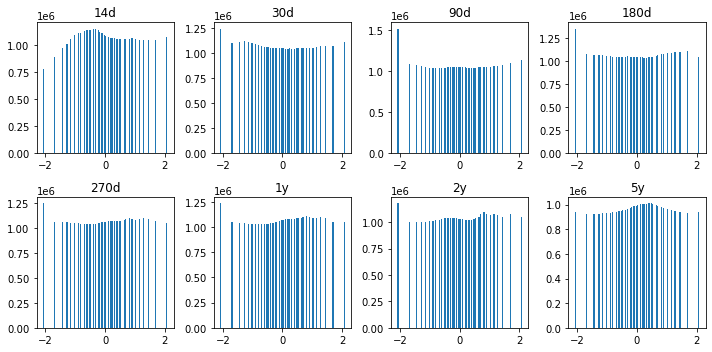

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.hist(spi[i].values.ravel(), bins=100)
    ax.set_title(intervals[i])

plt.tight_layout()

SPEI

In [5]:
spei = []

for interval in intervals:
    spei.append(xr.open_dataset(f'{dm_path}/spei/WA/spei_{interval}.nc')['spei'])

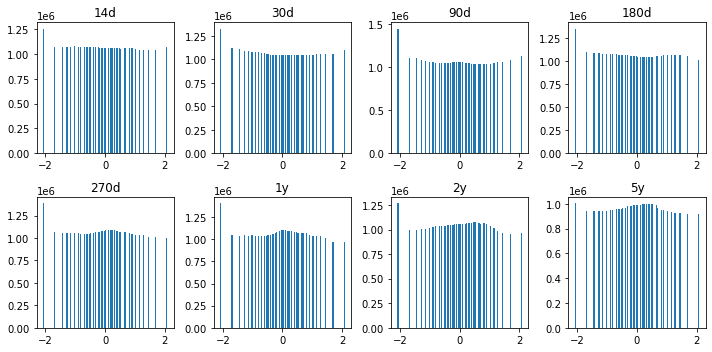

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.hist(spei[i].values.ravel(), bins=100)
    ax.set_title(intervals[i])

plt.tight_layout()

https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-evapotranspiration-index-spei

With SPEI being another standardized index like SPI, I'll use the same guidelines as above.

EDDI

In [7]:
eddi = []

for interval in intervals:
    eddi.append(xr.open_dataset(f'{dm_path}/eddi/WA/eddi_{interval}.nc')['eddi'])

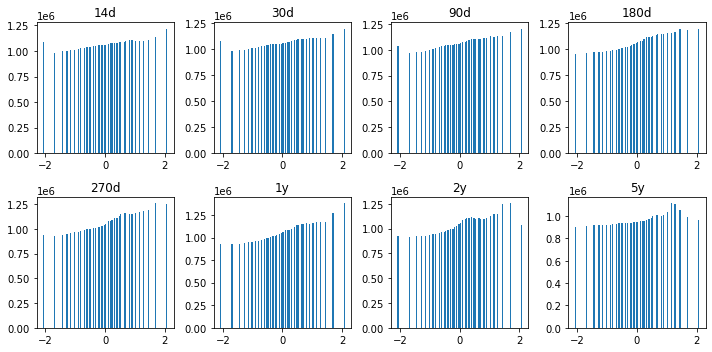

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(10,5))

for i, ax in enumerate(axs.ravel()):
    ax.hist(eddi[i].values.ravel(), bins=100)
    ax.set_title(intervals[i])

plt.tight_layout()

https://psl.noaa.gov/eddi/pdf/EDDI_UserGuide_v1.0.pdf

This also looks close to SPI range, so will use that as a guide as well

PDSI

In [9]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi.nc')['pdsi']

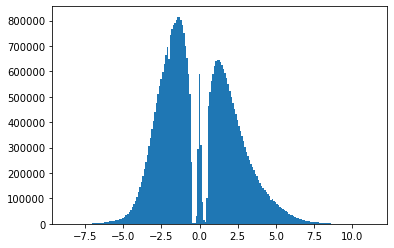

In [10]:
plt.hist(pdsi.values.ravel(), bins=200);

Well that's interesting. 

https://climatedataguide.ucar.edu/climate-data/palmer-drought-severity-index-pdsi

NCARR notes this spanning -10 to +10, but NOAA typically showing -4 to +4 range

In [11]:
pdsi_vals = pdsi.values.ravel()
pdsi_vals = pdsi_vals[np.isnan(pdsi_vals) == False]

In [12]:
quantiles = np.linspace(1,100, 200)
pdsi_percentiles = np.percentile(pdsi_vals, quantiles)

In [13]:
positions = np.arange(len(pdsi_vals))
plotting_pos = (positions - 0.4)/(len(pdsi_vals)+0.2)
pdsi_vals_sorted = np.sort(pdsi_vals.copy())

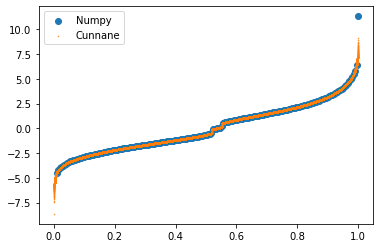

In [14]:
fig, ax = plt.subplots()

ax.scatter(quantiles/100, pdsi_percentiles, label='Numpy')
ax.scatter(plotting_pos[::1000], pdsi_vals_sorted[::1000], marker='.', s=1, label='Cunnane')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend()

https://journals.ametsoc.org/view/journals/apme/23/7/1520-0450_1984_023_1100_tpdsil_2_0_co_2.xml?tab_body=pdf

Describes categories for PDSI as:

- above -0.49: near normal
- -0.50 to -0.99: incipient drought (D0)
- -1.00 to -1.99: mild drought (D1)
- -2.00 to -2.99 moderate drought (D2)
- -3.00 to -3.99 severe drought (D3)
- less than -4.00: extreme drought (D4)

.... USDM site literally also has PDSI listed.
- D0: -1.0 to -1.9
- D1: -2.0 to -2.9
- D2: -3.0 to -3.9
- D3: -4.0 to -4.9
- D4: -5.0 or less

so we'll use those

In [49]:
np.percentile(pdsi_vals_sorted, [2, 5, 10, 20, 30])

array([-4.03000069, -3.42000008, -2.88000011, -2.20000076, -1.68000031])

In [50]:
np.percentile(pdsi_vals_sorted, 50)

-0.6599998474121094

In [52]:
np.arange(40,101,10)

array([ 40,  50,  60,  70,  80,  90, 100])

In [51]:
np.percentile(pdsi_vals_sorted, np.arange(40,101,10))

array([-1.20000076, -0.65999985,  0.85999966,  1.45999908,  2.13999939,
        3.17000008, 11.31999969])

In [53]:
np.std(pdsi_vals_sorted)

2.4201596

In [58]:
std = np.std(pdsi_vals_sorted)
mean = np.mean(pdsi_vals_sorted)

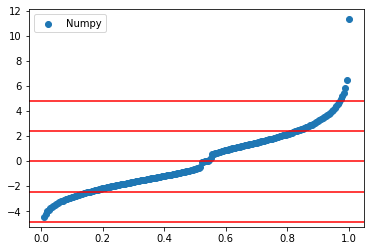

In [62]:
fig, ax = plt.subplots()

ax.scatter(quantiles/100, pdsi_percentiles, label='Numpy')
ax.axhline(-2*std+mean, color='r')
ax.axhline(-1*std+mean, color='r')
ax.axhline(0*std+mean, color='r')
ax.axhline(1*std+mean, color='r')
ax.axhline(2*std+mean, color='r')


plt.legend()

GRACE

In [15]:
grace = xr.open_dataset(f'{dm_path}/grace/WA/grace_wa.nc')

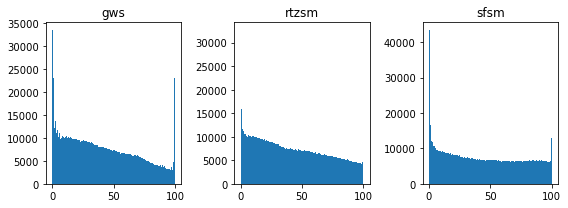

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(8,3))

for ax, var in zip(axs.ravel(), ['gws', 'rtzsm', 'sfsm']):
    ax.hist(grace[var].values.ravel(), bins=200)
    ax.set_title(var)

plt.tight_layout()

These are percentiles, so we can use the USDM guidance on objective percentiles here.

Palmer Z

In [17]:
palmer_z = xr.open_dataset(f'{dm_path}/palmer_z_index/WA/z.nc')['z']

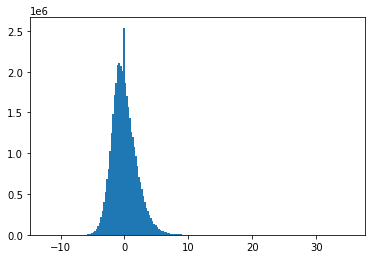

In [18]:
plt.hist(palmer_z.values.ravel(), bins=200);

In [19]:
palmer_z_vals = palmer_z.values.ravel()
palmer_z_vals = palmer_z_vals[np.isnan(palmer_z_vals) == False]

In [21]:
quantiles = np.linspace(1,100, 200)
z_percentiles = np.percentile(palmer_z_vals, quantiles)

In [23]:
positions = np.arange(len(palmer_z_vals))
plotting_pos = (positions - 0.4)/(len(palmer_z_vals)+0.2)
z_vals_sorted = np.sort(palmer_z_vals.copy())

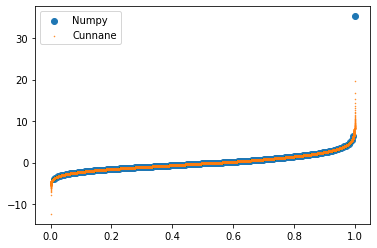

In [27]:
fig, ax = plt.subplots()

ax.scatter(quantiles/100, z_percentiles, label='Numpy')
ax.scatter(plotting_pos[::1000], z_vals_sorted[::1000], marker='.', s=1, label='Cunnane')
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.legend()

What if I just pull the USDM percentiles

In [29]:
np.percentile(palmer_z_vals, [2, 5, 10, 20, 30])

array([-3.47000027, -2.82999992, -2.26000023, -1.57999992, -1.09000015])

Okay, and where is 50%?

In [31]:
np.percentile(palmer_z_vals, 50)

-0.20000076293945312

In [32]:
np.quantile(palmer_z_vals, 0)

-12.37

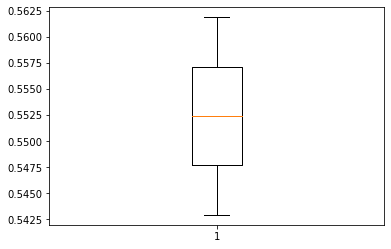

In [46]:
plt.boxplot(plotting_pos[np.where(z_vals_sorted == 0)[0]]);

So zero is a little above the 50% quantile. Should it be at the 50% quantile??

So thinking more on the USDM, I'd want to double check with researchers, but given that these metrics are computed based on percentiles that, besides USDM, depict both wet and dry conditions, it would make sense that all of the data as a whole is meant to follow a normal distribution. Now, looking at a specific region may change that based on it's climatology, but the metric itself shouldn't be putting a skew on the metric just by it's process. So I'm going to assume that the USDM percentiles are with an assumption that a 50th quantile is a measure of zero, that the metrics used are meant to be symmetrical around zero (disregarding climate change that may change that).

I cna develop then benchmarks for Z index through PDSI benchmarks knowing some of these principals perhaps? Or maybe I should just translate via the original math.

Looking at a few papers, I'm seeing the general relationship between Z and PDSI:

$(PDSI)_{i} = 0.897*(PDSI)_{i-1} + Z_i/3$

With i being the i-th month after a dry spell

One paper (Karl 1986) lists the following:
- near normal: -1.49 - 1.49 (PDSI), -1.24 - 0.99 (Z)
- mild to moderate drought: -1.50 - -2.99 (PDSI), -1.25 - -1.99 (Z)
- severe drought: -3.00 - -3.99 (PDSI), -2.00 - -2.74 (Z)
- extreme drought: <= -4.00 (PDSI), <= -2.75 (Z)

That puts D0 & D1 split amongst "near normal" and "mild to moderate drought", D2 in "severe drought", D3 & D4 in "extreme drought". This gives us thresholds for D2 clearly in Z, and maybe an ability to interpolate others

## Recategorizing:
- SPI: Already categorized right
- SPEI: DONE
- PDSI: DONE
- EDDI: DONE
- GRACE: DONE
- Z: DONE